## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. These will be uploaded for you the week of Oct 24th, at which point we'll update this notebook with a link. 

**Update:** This Google Drive [folder](https://drive.google.com/drive/folders/11GEhOPP0T4Oaw_Yhb4jD_fh79DNXq8no?usp=sharing) contains many additional slides and masks you can use. Note that while the starter code below downloads one slide from a Google Cloud URL (we have hosted this online for you for convenience), you will need to find a way to work with the other slides yourself for practice. You do not need to use them all! Just a few. You can either host the slides you'll use on Cloud storage using any provider, or you can download from Google Drive in your notebook (this may be slow).

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, on any topic of interest to you.

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,048 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [ ]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  82.7M      0  0:00:06  0:00:06 --:--:-- 89.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  51.8M      0 --:--:-- --:--:-- --:--:-- 51.6M


In [ ]:
def download_data(slide_path, tumor_mask_path):
    # Download the whole slide image
    if not os.path.exists(slide_path):
        !gsutil cp gs://coms4995_zl2822/{slide_path} .

    # Download the tumor mask
    if not os.path.exists(tumor_mask_path):
        !gsutil cp gs://coms4995_zl2822/{tumor_mask_path} .

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

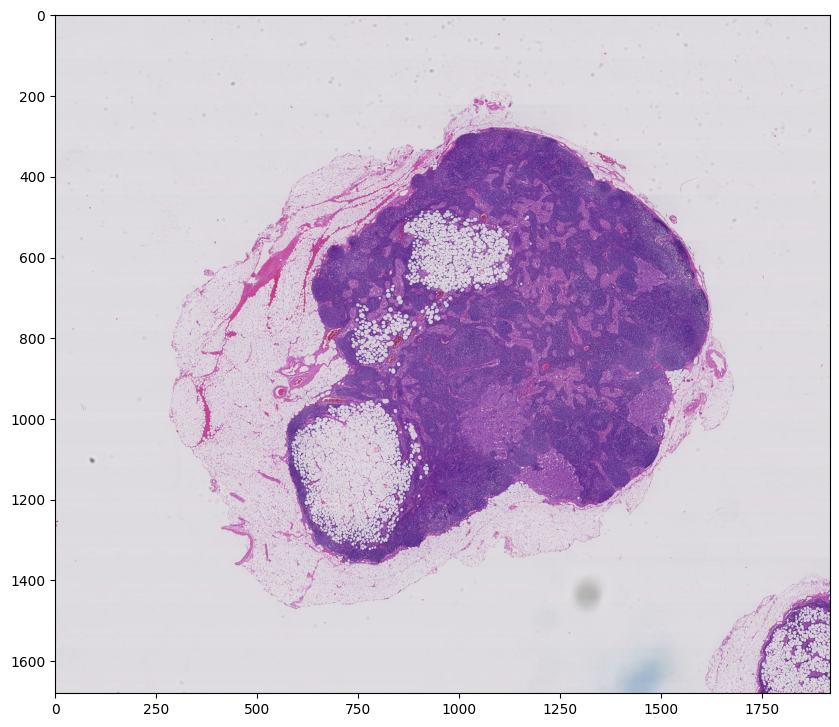

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

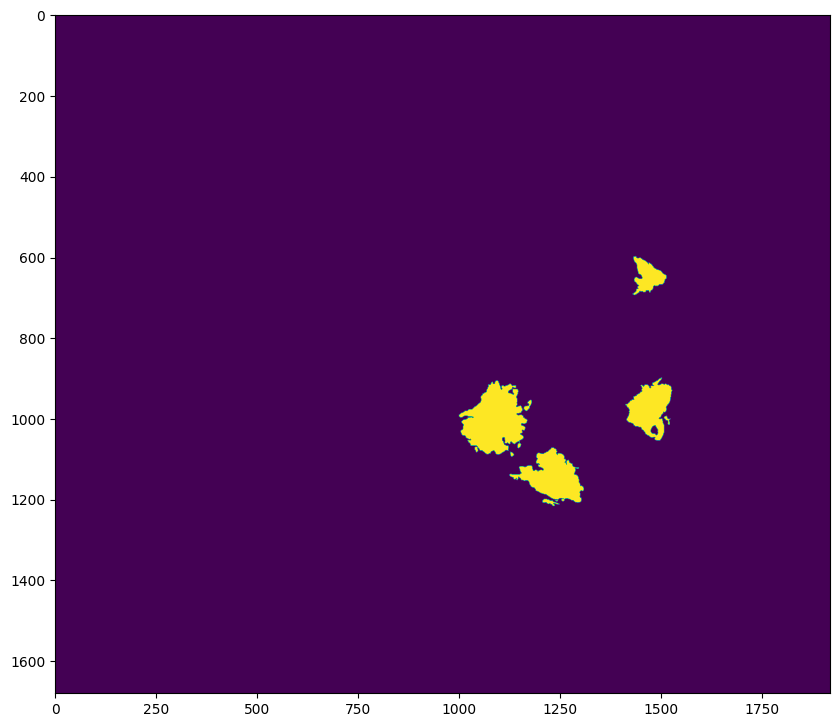

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

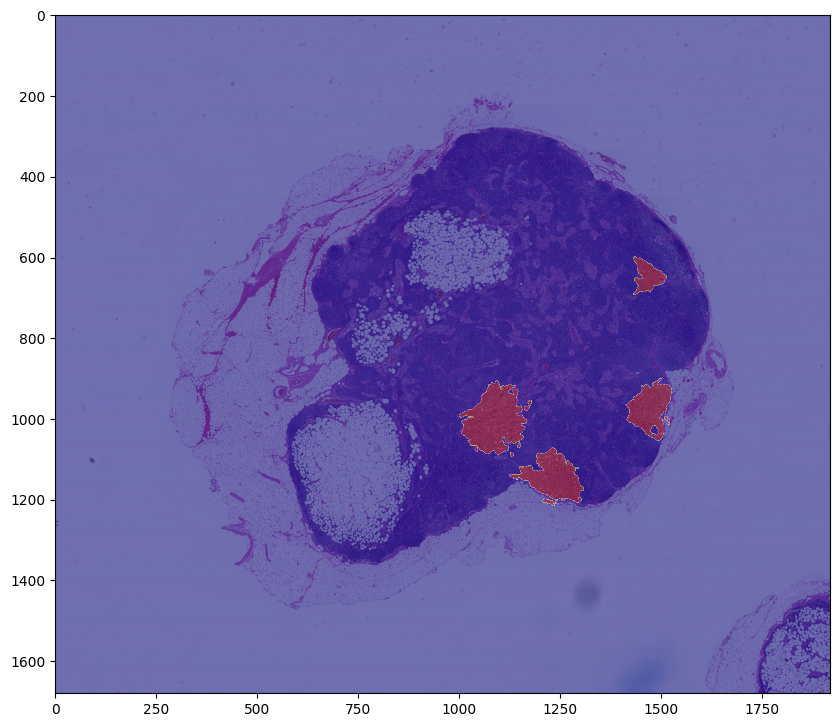

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

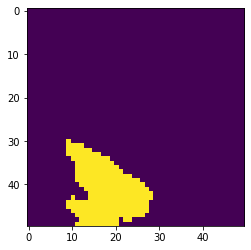

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (32.1 percent of the image)


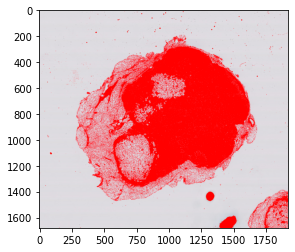

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

before doing this, perform "Add shortcut to Dive"on this folder (https://drive.google.com/drive/folders/11GEhOPP0T4Oaw_Yhb4jD_fh79DNXq8no) to "My Drive"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/slides

tumor_001_mask.tif  tumor_019.xml	tumor_059.xml	    tumor_091.tif
tumor_001.tif	    tumor_023_mask.tif	tumor_064_mask.tif  tumor_091.xml
tumor_001.xml	    tumor_023.tif	tumor_064.tif	    tumor_094_mask.tif
tumor_002_mask.tif  tumor_023.xml	tumor_064.xml	    tumor_094.tif
tumor_002.tif	    tumor_031_mask.tif	tumor_075_mask.tif  tumor_094.xml
tumor_002.xml	    tumor_031.tif	tumor_075.tif	    tumor_096_mask.tif
tumor_005_mask.tif  tumor_031.xml	tumor_075.xml	    tumor_096.tif
tumor_005.tif	    tumor_035_mask.tif	tumor_078_mask.tif  tumor_096.xml
tumor_005.xml	    tumor_035.tif	tumor_078.tif	    tumor_101_mask.tif
tumor_012_mask.tif  tumor_035.xml	tumor_078.xml	    tumor_101.tif
tumor_012.tif	    tumor_038.tif	tumor_081_mask.tif  tumor_101.xml
tumor_012.xml	    tumor_038.xml	tumor_081.tif	    tumor_110_mask.tif
tumor_016_mask.tif  tumor_057_mask.tif	tumor_081.xml	    tumor_110.tif
tumor_016.tif	    tumor_057.tif	tumor_084_mask.tif  tumor_110.xml
tumor_016.xml	    tumor_057.xml	tumor_084.ti

In [ ]:
open_slide(os.path.join('/content/gdrive/MyDrive/slides/', 'tumor_059.tif'))

OpenSlide('/content/gdrive/MyDrive/slides/tumor_059.tif')

In [ ]:
tumors = []
slides = []
tumornames = []
slidenames = []

for slide in os.listdir('/content/gdrive/MyDrive/slides/'):
  if "tif" in slide and '91' not in slide:
      if "mask" in slide:
          try:
            tumors.append(open_slide(os.path.join('/content/gdrive/MyDrive/slides/', slide)))
            tumornames.append(slide)
            print("ok for"+ os.path.join('/content/gdrive/MyDrive/slides/', slide))
          except:
            print("not ok for"+ os.path.join('/content/gdrive/MyDrive/slides/', slide))
      else:
          try:
            slides.append(open_slide(os.path.join('/content/gdrive/MyDrive/slides/', slide)))
            slidenames.append(slide)
            print("ok for"+ os.path.join('/content/gdrive/MyDrive/slides/', slide))
          except:
            print("not ok for"+ os.path.join('/content/gdrive/MyDrive/slides/', slide))

ok for/content/gdrive/MyDrive/slides/tumor_002_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_001_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_012_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_075_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_016_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_084_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_096_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_110_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_031_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_081_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_059_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_078_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_101_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_094_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_019_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_023_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_035_mask.tif
ok for/content/gdrive/MyDrive/slides/tumor_057_m

In [ ]:
def find_zoom_images(slide, i, j, num_of_windows=30, zoom_levels=[4,5,6], d = (61440,53760)):
  # The function zooms the images for various levels
  # slide:the image that is slided on
  # i,j:the index of every window
  dx = int(slide.level_dimensions[3][0]/num_of_windows)
  dy = int(slide.level_dimensions[3][1]/num_of_windows) 
  factor = slide.level_downsamples[3]
  output = []

  for l in zoom_levels:
 
    delta_x = round(dx*(2**l-2**(l-1))/2)
    delta_y = round(dy*(2**l-2**(l-1))/2)
    
    f_l = slide.level_downsamples[l]

    x = dx*i*factor - delta_x
    y = dy*j*factor - delta_y

    if i >= num_of_windows-(l-3):
      x = d[0] - dx * f_l
    elif i < 0 :
      x = 0

    if j >= num_of_windows-(l-3):
      y = d[1] - dy * f_l
    elif j < 0:
      y = 0

    r = read_slide(slide,x=int(x), y=int(y), level=l, width=dx, height=dy)
    output.append(r)
  
  return output

created folders "adl_final_project/label 1" and "adl_final_project/label 0"

In [ ]:
!ls /content/gdrive/MyDrive/adl_final_project

 activations.npy		 'label 1'		       test_labels.npy
 ADL_Final_Presentation.gslides   labels.npy		       Untitled
 final_model			  project_starter_code.ipynb
'label 0'			  test_activations.npy


In [ ]:
# write windows into two classes: 01 or 00 classes
slides_p = slides[5:10]
tumors_p = tumors[5:10]
slidenames_p = slidenames[5:10]
ROOT_PATH_1 = '/content/gdrive/MyDrive/adl_final_project/label 1/'
ROOT_PATH_0 = '/content/gdrive/MyDrive/adl_final_project/label 0/'
for slide_idx, slide in enumerate(slides_p):
# slide over level 3, 30*30 patches in a slide
  d = slide.level_dimensions[0]
  w = int(slide.level_dimensions[3][0]/30)
  h = int(slide.level_dimensions[3][1]/30)
  factor = int(slide.level_downsamples[3])
  count = 0
  tumor_mask = tumors_p[slide_idx]
  filename = slidenames_p[slide_idx].split('.')[0]
  for i in range(30):
    for j in range(30):
      region = read_slide(slide, x=i*w*factor, y=j*h*factor, level=3, width=w, height=h)
      region_mask = read_slide(tumor_mask, x=i*w*factor, y=j*h*factor, level=3, width=w, height=h)[:,:,0]
      tissue_pixels = find_tissue_pixels(region)
      percent_tissue = len(tissue_pixels) / float(region.shape[0] * region.shape[1]) * 100
      
      if percent_tissue > 10:   
        # only goes in if the area of tissues is larger than 10% of entire area
        zoom1, zoom2, zoom3 = find_zoom_images(slide, i, j, d = d)     
        im1 = Image.fromarray(region)
        im2 = Image.fromarray(zoom1)
        im3 = Image.fromarray(zoom2)
        im4 = Image.fromarray(zoom3)
        row_labels = 0
        for row in region_mask:
          if 1 in row:
            row_labels=1
            break

        if 1 == row_labels:  
          # if the window has tumor, write 4 images to 01 folder
          ROOT_PATH = ROOT_PATH_1     
        else:
          ROOT_PATH = ROOT_PATH_0

        # save the images to Google drive
        temp = filename + '_' + str(i) + '_' + str(j) + '_' + str(0)
        temp_path = os.path.join(ROOT_PATH, temp + '.jpg')
        im1.save(temp_path)

        temp = filename + '_' + str(i) + '_' + str(j) + '_' + str(1)
        temp_path = os.path.join(ROOT_PATH, temp + '.jpg')
        im2.save(temp_path)

        temp = filename + '_' + str(i) + '_' + str(j) + '_' + str(2)
        temp_path = os.path.join(ROOT_PATH, temp + '.jpg')
        im3.save(temp_path)

        temp = filename + '_' + str(i) + '_' + str(j) + '_' + str(3)
        temp_path = os.path.join(ROOT_PATH, temp + '.jpg')
        im4.save(temp_path)  

  print(filename, 'slided!') 

tumor_019 slided!
tumor_012 slided!
tumor_016 slided!
tumor_023 slided!
tumor_031 slided!


In [ ]:
ROOT_PATH_1 = '/content/gdrive/MyDrive/adl_final_project/label 1/'
ROOT_PATH_0 = '/content/gdrive/MyDrive/adl_final_project/label 0/'
health_slide_paths = os.listdir(ROOT_PATH_0)
tumor_slide_paths = os.listdir(ROOT_PATH_1)

health_windows = np.array(health_slide_paths).reshape((int(len(health_slide_paths)/4), 4))
tumor_windows = np.array(tumor_slide_paths).reshape((int(len(tumor_slide_paths)/4), 4))
     

In [ ]:
import random
random.shuffle(health_windows)
health_test_size = round(len(health_windows)*0.2)
test_health_path = health_windows[:health_test_size]
train_health_path = health_windows[health_test_size:]

random.shuffle(tumor_windows)
tumor_test_size = round(len(tumor_windows)*0.2)
test_tumor_path = tumor_windows[:tumor_test_size]
train_tumor_path = tumor_windows[tumor_test_size:]

In [ ]:
len(health_slide_paths)/(len(health_slide_paths) + len(tumor_slide_paths))


0.9850299401197605

In [ ]:
# image load and processing function
def image_processing(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.vgg16.preprocess_input(img)
  return activations


def image_processing_VGG(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.inception_v3.preprocess_input(img)
  return activations

In [ ]:
def color_augmentation(image, brightness = 64/255, saturation = 0.25, hue = 0.04, contrast = 0.75):
  temp = tf.image.random_brightness(image, brightness)
  temp = tf.image.adjust_saturation(temp, 0, saturation)
  temp = tf.image.random_hue(temp, hue)
  result = tf.image.random_contrast(temp, 0, contrast)
  return result

def rotation(image):
  temp = tf.image.rot90(image)
  temp = tf.image.flip_left_right(temp)
  result = tf.image.rot90(temp)
  return result

def cancer_image_processing(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img1 = color_augmentation(img)
  img2 = rotation(img)
  activations1 = tf.keras.applications.inception_v3.preprocess_input(img1)
  activations2 = tf.keras.applications.inception_v3.preprocess_input(img2)
  return activations1, activations2

In [ ]:
def read_health_slide(paths):
  X = []
  idx = 0
  while idx < len(paths) - 3:
    if random.random() > 0.5:  
      # randomly select healthly tissue with probability of 50%
      region = image_processing(os.path.join(ROOT_PATH_0, paths[idx]))
      zoom1 = image_processing(os.path.join(ROOT_PATH_0, paths[idx+1]))
      zoom2 = image_processing(os.path.join(ROOT_PATH_0, paths[idx+2]))
      zoom3 = image_processing(os.path.join(ROOT_PATH_0, paths[idx+3]))
      X.append([region, zoom1, zoom2, zoom3])
    idx += 4  
  y = [0]*len(X)
  return X, y


In [ ]:
def read_tumor_slide(paths):
  idx = 0
  X = []
  y = []
  while idx < len(paths) - 3:
    region = image_processing(os.path.join(ROOT_PATH_1, paths[idx]))
    zoom1 = image_processing(os.path.join(ROOT_PATH_1, paths[idx+1]))
    zoom2 = image_processing(os.path.join(ROOT_PATH_1, paths[idx+2]))
    zoom3 = image_processing(os.path.join(ROOT_PATH_1, paths[idx+3]))
    region1, region2 = cancer_image_processing(os.path.join(ROOT_PATH_1, paths[idx]))
    zoom11, zoom12 = cancer_image_processing(os.path.join(ROOT_PATH_1, paths[idx+1]))
    zoom21, zoom22 = cancer_image_processing(os.path.join(ROOT_PATH_1, paths[idx+2]))
    zoom31, zoom32 = cancer_image_processing(os.path.join(ROOT_PATH_1, paths[idx+3]))

    X.append([region, zoom1, zoom2, zoom3])
    y.append(1)
    idx += 4


    X.append([region1, zoom11, zoom21, zoom31])
    X.append([region2, zoom12, zoom22, zoom32])  
    y.append(1)
    y.append(1)
    
  return X,y


In [ ]:
def read_test_slide(paths, ROOT_PATH):
  X = []
  idx = 0
  while idx < len(paths) - 3:
    region = image_processing(os.path.join(ROOT_PATH, paths[idx]))
    zoom1 = image_processing(os.path.join(ROOT_PATH, paths[idx+1]))
    zoom2 = image_processing(os.path.join(ROOT_PATH, paths[idx+2]))
    zoom3 = image_processing(os.path.join(ROOT_PATH, paths[idx+3]))
    X.append([region, zoom1, zoom2, zoom3])
    idx += 4  
  if ROOT_PATH == '/content/gdrive/MyDrive/adl_final_project/label 1/':
    y = [1]*len(X)
  else:
    y = [0]*len(X)
  return X, y

In [ ]:
import tensorflow as tf

X_train_health, y_train_health = read_health_slide(train_health_path.reshape(-1))
X_train_tumor, y_train_tumor = read_tumor_slide(train_tumor_path.reshape(-1))

X_test_health, y_test_health = read_test_slide(test_health_path.reshape(-1), ROOT_PATH_0)
X_test_tumor, y_test_tumor = read_test_slide(test_tumor_path.reshape(-1), ROOT_PATH_1)

In [ ]:
X_train = np.concatenate((np.array(X_train_health), np.array(X_train_tumor)), axis = 0)
y_train = np.concatenate((np.array(y_train_health), np.array(y_train_tumor)), axis = 0)

X_test = np.concatenate((np.array(X_test_health), np.array(X_test_tumor)), axis = 0)
y_test = np.concatenate((np.array(y_test_health), np.array(y_test_tumor)), axis = 0)
     

In [ ]:
np.array(X_train).shape


(140, 4, 299, 299, 3)

In [ ]:
np.array(X_test).shape

(67, 4, 299, 299, 3)

In [ ]:
# Create a feature extraction model for InceptionV3.
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Create a feature extraction model for VGG16.
VGG_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet')
new_input = VGG_model.input
hidden_layer = VGG_model.layers[-1].output
image_features_extract_model_VGG = tf.keras.Model(new_input, hidden_layer)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
def save_feature(X, y, type):
  # X: the array of sliding windows with zoom of different magnitude
  # y: the array of labels for the corresponding sliding window

  activation_dataset = tf.data.Dataset.from_tensor_slices(X)
  result = []
  for img_batch in activation_dataset:
    batch_features = image_features_extract_model(img_batch)
    result.append(batch_features.numpy())

  # save the activations
  result = np.array(result)
  if type == 'train':
    PATH = '/content/gdrive/MyDrive/adl_final_project/activations.npy'
  else:
    PATH = '/content/gdrive/MyDrive/adl_final_project/test_activations.npy'
  try:
    feature = np.load(PATH)
    feature = np.concatenate((feature, result), axis=0)
    np.save(PATH, feature)
    print('Activation file saved.')
  except FileNotFoundError as e:
    feature = result
    np.save(PATH, result)
    print('Activation file created.')

  # save the labels:
  l = np.array(y)
  if type == 'train':
    PATH = '/content/gdrive/MyDrive/adl_final_project/labels.npy'
  else:
    PATH = '/content/gdrive/MyDrive/adl_final_project/test_labels.npy'
  try:
    labels = np.load(PATH)
    labels = np.concatenate((labels, l), axis=0)
    np.save(PATH, labels)
    print('Label file saved.')
  except FileNotFoundError as e:
    labels = l
    np.save(PATH, l)
    print('Label file created.')

  return feature,labels

In [ ]:
X, y = save_feature(X_train, y_train, type = 'train')


Activation file saved.
Label file saved.


In [ ]:
X_test, y_test = save_feature(X_test, y_test, type = 'test')


Activation file saved.
Label file saved.


In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential

In [ ]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

dense = Dense(512, activation='relu')(encoded_image)
output = Dense(1, activation='sigmoid')(dense)

base_model = Model(inputs=image_input, outputs=output)

In [ ]:
base_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 8, 2048)]      0         
                                                                 
 sequential (Sequential)     (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,049,601
Trainable params: 1,049,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
     

In [ ]:
image_input1 = Input(shape=(8, 8, 2048)) 
vision_model1 = Sequential()
vision_model1.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image1 = vision_model1(image_input1) 

image_input2 = Input(shape=(8, 8, 2048)) 
vision_model2 = Sequential()
vision_model2.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image2 = vision_model2(image_input2) 

image_input3 = Input(shape=(8, 8, 2048)) 
vision_model3 = Sequential()
vision_model3.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image3 = vision_model3(image_input3) 

image_input4 = Input(shape=(8, 8, 2048)) 
vision_model4 = Sequential()
vision_model4.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image4 = vision_model4(image_input4) 

merged = tf.keras.layers.concatenate([encoded_image1, encoded_image2, encoded_image3, encoded_image4])

dense = Dense(512, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[image_input1, image_input2, image_input3, image_input4], outputs=output)

In [ ]:
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 input_5 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                           

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
     

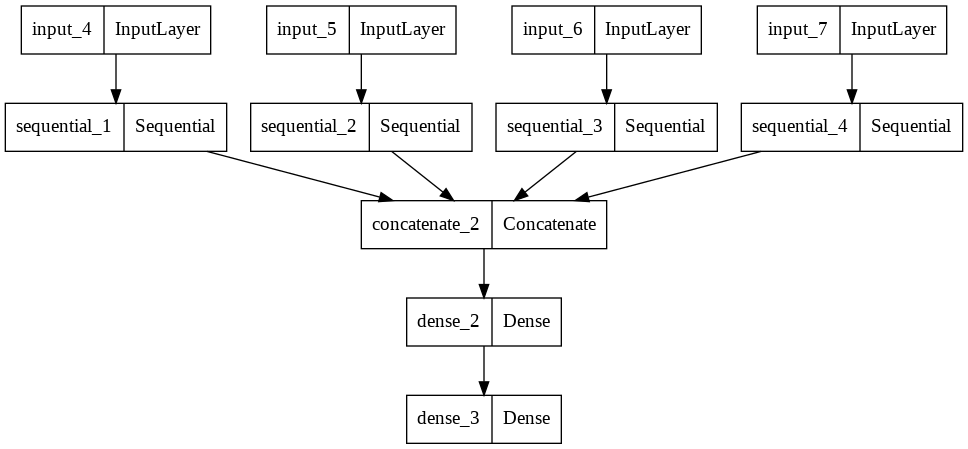

In [ ]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
# read the features and labels from Google Drive
activation = np.load('/content/gdrive/MyDrive/adl_final_project/activations.npy')
labels = np.load('/content/gdrive/MyDrive/adl_final_project/labels.npy')

In [ ]:
# random shuffle training set
indices = np.arange(activation.shape[0])
np.random.shuffle(indices)
activation = activation[indices]
labels = labels[indices]
     

In [ ]:
image1 = activation[:,0,:,:]
image2 = activation[:,1,:,:]
image3 = activation[:,2,:,:]
image4 = activation[:,3,:,:]
image1.shape

(281, 8, 8, 2048)

In [ ]:
base_hist = base_model.fit(image1, labels, validation_split= 0.3, epochs=8)


Epoch 1/8
7/7 [==============================] - 1s 35ms/step - loss: 6.7762 - accuracy: 0.8520 - val_loss: 5.1697 - val_accuracy: 0.9059
Epoch 2/8
7/7 [==============================] - 0s 15ms/step - loss: 5.4652 - accuracy: 0.9184 - val_loss: 1.4201 - val_accuracy: 0.9765
Epoch 3/8
7/7 [==============================] - 0s 14ms/step - loss: 0.6045 - accuracy: 0.9337 - val_loss: 0.2859 - val_accuracy: 0.9765
Epoch 4/8
7/7 [==============================] - 0s 14ms/step - loss: 0.7509 - accuracy: 0.9694 - val_loss: 0.2040 - val_accuracy: 0.9529
Epoch 5/8
7/7 [==============================] - 0s 14ms/step - loss: 0.3971 - accuracy: 0.9592 - val_loss: 0.0818 - val_accuracy: 0.9882
Epoch 6/8
7/7 [==============================] - 0s 16ms/step - loss: 0.0816 - accuracy: 0.9847 - val_loss: 0.5988 - val_accuracy: 0.9176
Epoch 7/8
7/7 [==============================] - 0s 16ms/step - loss: 0.0628 - accuracy: 0.9898 - val_loss: 0.1233 - val_accuracy: 0.9882
Epoch 8/8
7/7 [===================

In [ ]:
history = model.fit([image1, image2, image3, image4], labels, validation_split= 0.3, epochs=5)


Epoch 1/5
7/7 [==============================] - 1s 69ms/step - loss: 24.1423 - accuracy: 0.7653 - val_loss: 16.1502 - val_accuracy: 0.9059
Epoch 2/5
7/7 [==============================] - 0s 40ms/step - loss: 13.4833 - accuracy: 0.9184 - val_loss: 0.4168 - val_accuracy: 0.9765
Epoch 3/5
7/7 [==============================] - 0s 40ms/step - loss: 1.1746 - accuracy: 0.9235 - val_loss: 2.0544 - val_accuracy: 0.9765
Epoch 4/5
7/7 [==============================] - 0s 39ms/step - loss: 3.0668 - accuracy: 0.9694 - val_loss: 0.1864 - val_accuracy: 0.9882
Epoch 5/5
7/7 [==============================] - 0s 36ms/step - loss: 0.4409 - accuracy: 0.9745 - val_loss: 9.6243e-05 - val_accuracy: 1.0000


In [ ]:
test_activations = np.load('/content/gdrive/MyDrive/adl_final_project/test_activations.npy')
test_labels = np.load('/content/gdrive/MyDrive/adl_final_project/test_labels.npy')
image1 = test_activations[:,0,:,:]
image2 = test_activations[:,1,:,:]
image3 = test_activations[:,2,:,:]
image4 = test_activations[:,3,:,:]
res = model.predict([image1, image2, image3, image4])

5/5 [==============================] - 0s 13ms/step


In [ ]:
model.save('/content/gdrive/MyDrive/adl_final_project/final_model')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

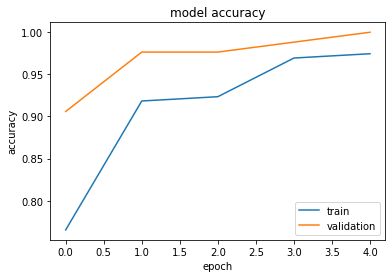

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
     

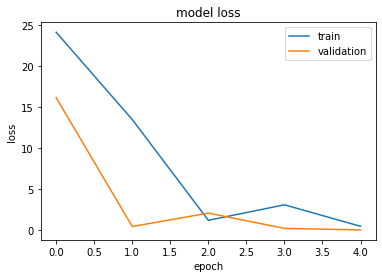

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
     

In [ ]:
slide = open_slide('/content/gdrive/MyDrive/slides/tumor_078.tif')
tumor = open_slide('/content/gdrive/MyDrive/slides/tumor_078_mask.tif')

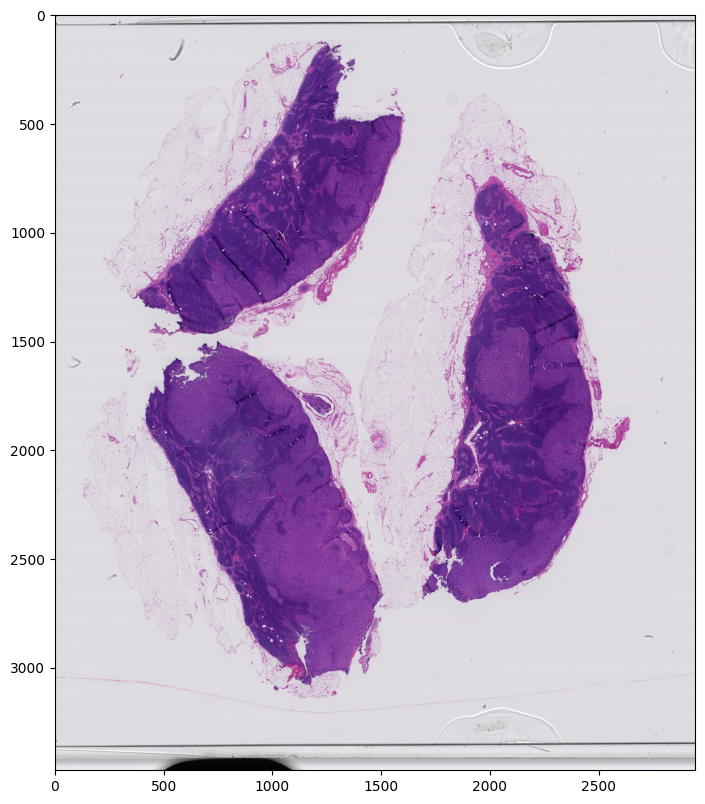

In [ ]:

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

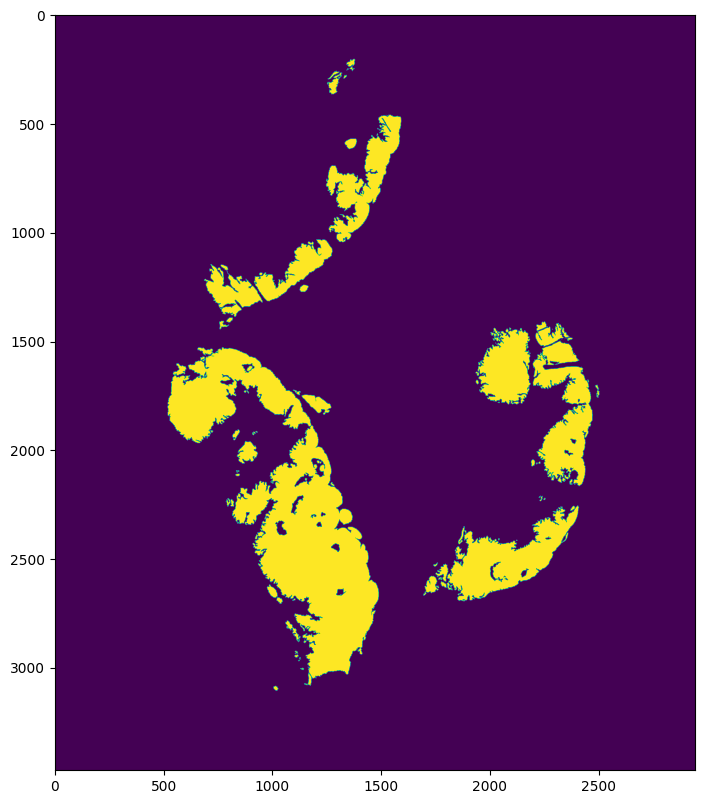

In [ ]:
mask_image = read_slide(tumor, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

In [ ]:
def find_new_slide(slide, tumor):
  d = slide.level_dimensions[0]
  w = int(slide.level_dimensions[3][0]/30)
  h = int(slide.level_dimensions[3][1]/30)
  factor = int(slide.level_downsamples[3])
  count = 0

  output = []
  is_taken = []

  for i in range(30):
    for j in range(30):

      region = read_slide(slide, x=i*w*factor, y=j*h*factor, level=3, width=w, height=h)
      region_mask = read_slide(tumor, x=i*w*factor, y=j*h*factor, level=3, width=w, height=h)[:,:,0]
      tissue_pixels = find_tissue_pixels(region)
      percent_tissue = len(tissue_pixels) / float(region.shape[0] * region.shape[1]) * 100
      
      if percent_tissue > 10:   # the area of tissue takes > 10% of entire area
        is_taken.append(True)
        zoom1, zoom2, zoom3 = find_zoom_images(slide, i, j, d = d)     

        window = np.array([region, zoom1, zoom2, zoom3])

        output.append(window)
      else:
        is_taken.append(False)

  return np.array(output), is_taken

In [ ]:
windows, is_taken = find_new_slide(slide, tumor)

act = []
for slide in windows:
  slide = tf.image.resize(slide, (299,299))
  activations = tf.keras.applications.inception_v3.preprocess_input(slide)
  act.append(activations)

# activation matrix for the slides
act = np.array(act)

# get the feature matrix
activation_dataset = tf.data.Dataset.from_tensor_slices(act)
result = []
for img_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  result.append(batch_features.numpy())

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/adl_final_project/final_model')

In [ ]:
features = np.array(result)

image1 = features[:,0,:,:]
image2 = features[:,1,:,:]
image3 = features[:,2,:,:]
image4 = features[:,3,:,:]

res = new_model.predict([image1, image2, image3, image4])

14/14 [==============================] - 0s 21ms/step


In [ ]:
def predict_tumor(result, is_taken):
  #c_res = result
  c_res = np.where(result > 0.4, 1, 0)

  pred = []
  c_res = c_res.reshape(-1)
  for b in is_taken:
    if b:
      pred.append(c_res[0])
      c_res=np.delete(c_res,[0])
    else:
      pred.append(0)
  

  return np.array(pred).reshape((30,30)).T

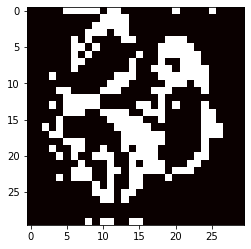

In [ ]:
pred = predict_tumor(res, is_taken)
plt.imshow(pred, cmap='hot', interpolation='nearest')

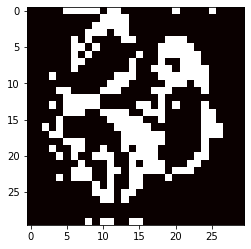

In [ ]:
pred = predict_tumor(res, is_taken)
plt.imshow(pred, cmap='hot', interpolation='nearest')

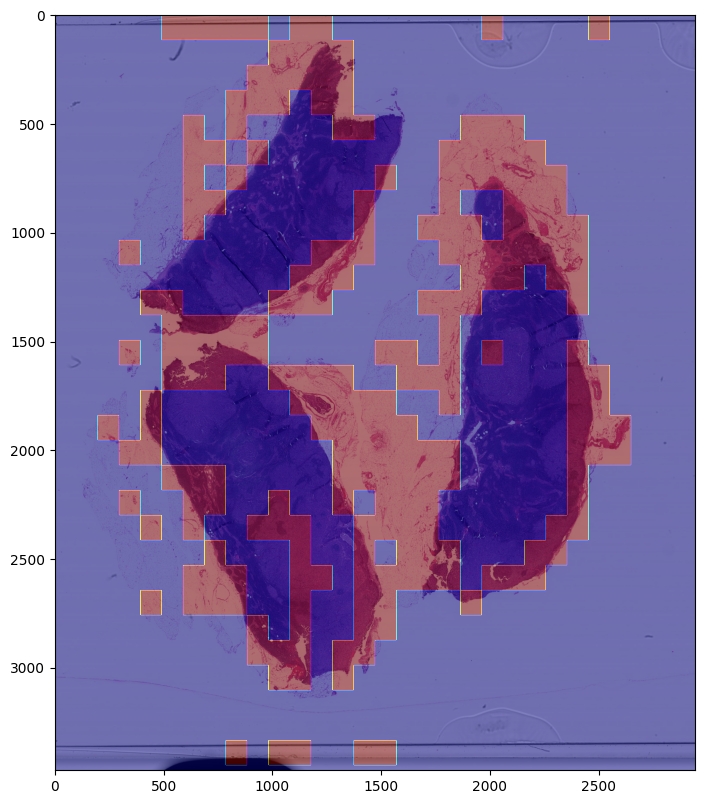

In [ ]:
pred = predict_tumor(res, is_taken)
c_res = pred.reshape((30,30))
p = np.zeros((slide.level_dimensions[5][1], slide.level_dimensions[5][0]))
x = int(slide.level_dimensions[5][1]/30)
y = int(slide.level_dimensions[5][0]/30)
for i in range(1,31):
  for j in range(1,31):
    if c_res[i-1][j-1] != 0:
      p[(i-1)*x:i*x,(j-1)*y:j*y] = np.ones((x,y))*c_res[i-1][j-1]


region = read_slide(slide, x=0, y=0, level=5, width=slide.level_dimensions[5][0], height=slide.level_dimensions[5][1])
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(region)
plt.imshow(p, cmap='jet', alpha=0.5)